In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook timm
import fastbook
fastbook.setup_book()

In [2]:
import timm
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastbook import search_images_ddg

# Getting the data

In [3]:
insects = ['millipede', 'centipede', 'caterpillar']
path = Path('insects')

In [4]:
if not path.exists():
    path.mkdir()
    for insect in insects:
        dest = (path/insect)
        dest.mkdir(exist_ok=True)
        urls = search_images_ddg(f'{insect}')
        download_images(urls=urls, dest=dest)

In [5]:
path.ls()

(#3) [Path('insects/centipede'),Path('insects/millipede'),Path('insects/caterpillar')]

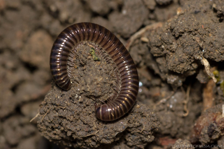

In [6]:
sample = (path/'millipede').ls()[0]
im = Image.open(sample)
im.to_thumb(224, 224)

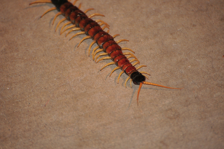

In [7]:
sample = (path/'centipede').ls()[0]
im = Image.open(sample)
im.to_thumb(224, 224)

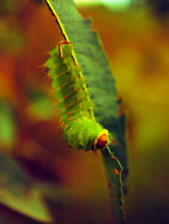

In [8]:
sample = (path/'caterpillar').ls()[0]
im = Image.open(sample)
im.to_thumb(224, 224)

In [9]:
for insect in insects:
    print(f'insect: {insect}, number: {len((path/insect).ls())}')

insect: millipede, number: 184
insect: centipede, number: 192
insect: caterpillar, number: 189


In [10]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

# Creating a Baseline

In [4]:
dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            get_y=parent_label,
            splitter=RandomSplitter(seed=42),
            item_tfms=RandomResizedCrop(224, min_scale=0.5))

In [13]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 561 items
2 datasets of sizes 449,112
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      insects/millipede/53fc239f-c11b-4c92-9ad0-915957674f0d.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1280x850
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      insects/millipede/53fc239f-c11b-4c92-9ad0-915957674f0d.jpg
    applying parent_label gives
      millipede
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PILImage mode=RGB size=1280x850, TensorCategory(2))


Found 561 items
2 datasets of sizes 449,112
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up

In [14]:
dls = dblock.dataloaders(path)

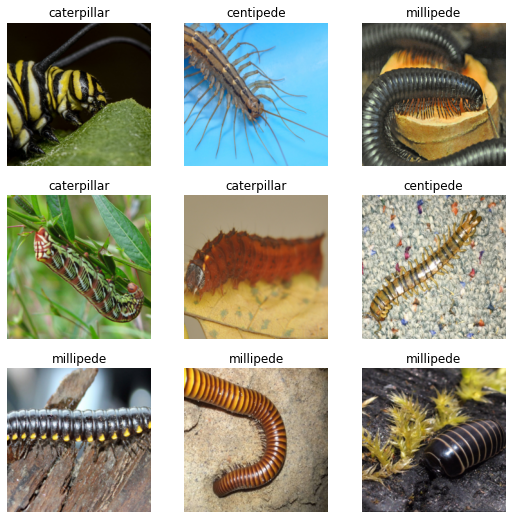

In [15]:
dls.train.show_batch()

In [16]:
learn = vision_learner(dls, arch=resnet18, pretrained=False, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0003311311302240938)

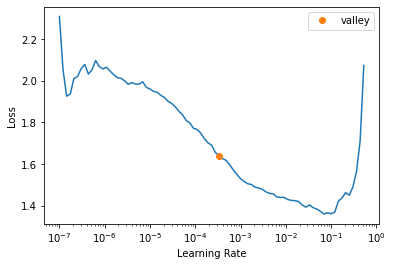

In [17]:
learn.lr_find()

In [22]:
learn.fit(10, lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.629990,1.308899,0.571429,00:06
1,0.647125,1.201464,0.598214,00:06
2,0.617324,1.020347,0.589286,00:06
3,0.586604,1.047875,0.633929,00:06
4,0.590294,1.179428,0.598214,00:06
5,0.578183,1.041951,0.571429,00:07
6,0.564578,1.063394,0.660714,00:06
7,0.539564,1.087738,0.589286,00:07
8,0.541352,1.075677,0.633929,00:07
9,0.534757,1.160585,0.651786,00:06


# Improving the Model

## a) Cleaning the data

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

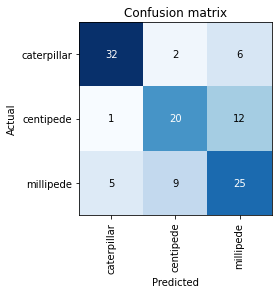

In [20]:
interp.plot_confusion_matrix()

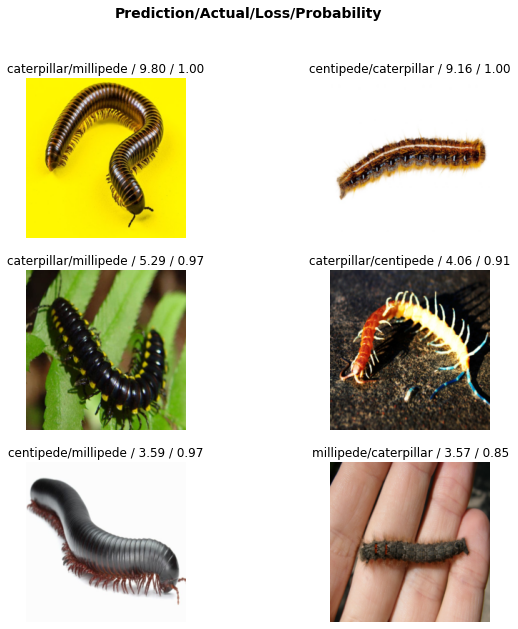

In [21]:
interp.plot_top_losses(k=6, nrows=3, figsize=(10,10))

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
dls = dblock.dataloaders(path)

In [29]:
learn = vision_learner(dls, arch=resnet18, pretrained=False, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit(10, lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.959085,417.480164,0.357143,00:07
1,1.501169,125.615318,0.357143,00:07
2,1.314491,17.856888,0.357143,00:06
3,1.161941,3.423977,0.464286,00:06
4,1.068379,1.590003,0.517857,00:06
5,1.001137,3.260970,0.508929,00:06
6,0.938896,1.513425,0.553571,00:06
7,0.885058,1.276793,0.633929,00:07
8,0.841374,1.326213,0.589286,00:06
9,0.804490,1.017544,0.589286,00:06


## b) Pretrained Model

In [30]:
learn = vision_learner(dls, arch=resnet18, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0008317637839354575)

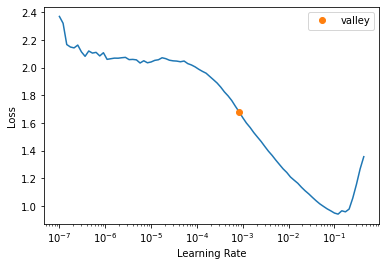

In [31]:
learn.lr_find()

In [32]:
learn.fit(10, lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.493397,5.979974,0.553571,00:07
1,1.133341,17.029814,0.482143,00:06
2,1.037795,4.181496,0.651786,00:06
3,0.916816,1.470768,0.776786,00:06
4,0.899479,2.682775,0.714286,00:06
5,0.854410,1.374917,0.830357,00:06
6,0.765372,1.089912,0.848214,00:06
7,0.698313,1.414372,0.785714,00:06
8,0.620235,2.899143,0.705357,00:06
9,0.552140,1.662160,0.794643,00:06


## c) Augmentations

In [5]:
dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            get_y=parent_label,
            splitter=RandomSplitter(seed=42),
            item_tfms=RandomResizedCrop(224, min_scale=0.5),
            batch_tfms=aug_transforms())

In [6]:
dls = dblock.dataloaders(path)

In [36]:
learn = vision_learner(dls, arch=resnet18, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

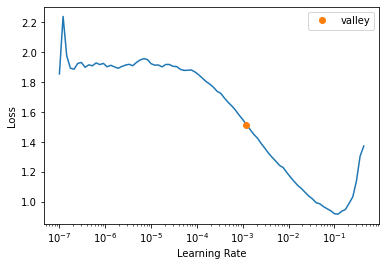

In [37]:
learn.lr_find()

In [38]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.040078,0.998627,0.750000,00:06
1,0.715323,0.553207,0.848214,00:06
2,0.555363,0.419837,0.901786,00:06
3,0.445000,0.413472,0.892857,00:06
4,0.376438,0.437765,0.848214,00:07
5,0.321526,0.443171,0.875000,00:06
6,0.281951,0.449143,0.875000,00:06
7,0.247060,0.431489,0.875000,00:06
8,0.217692,0.415946,0.883929,00:06
9,0.195850,0.435383,0.892857,00:07


## d) Learning Rate Scheduling

In [39]:
learn = vision_learner(dls, arch=resnet18, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [40]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.993002,1.045324,0.544643,00:06
1,1.447800,0.496457,0.785714,00:06
2,1.050055,0.471426,0.848214,00:06
3,0.835623,0.453243,0.883929,00:07
4,0.676756,0.435658,0.892857,00:06
5,0.564385,0.420974,0.901786,00:07
6,0.491622,0.412781,0.901786,00:06
7,0.428168,0.412300,0.901786,00:06
8,0.388304,0.411616,0.901786,00:06
9,0.350503,0.420127,0.901786,00:06


## e) Different Models

https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning

In [41]:
learn = vision_learner(dls, arch=resnet34, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

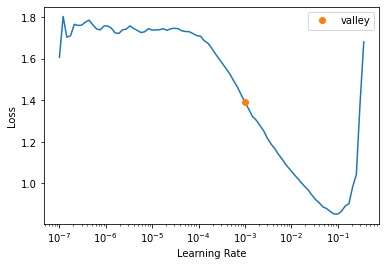

In [42]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.510600,1.348115,0.571429,00:07
1,1.187363,0.517703,0.830357,00:07
2,0.855175,0.456228,0.857143,00:07
3,0.670456,0.421848,0.857143,00:07
4,0.545408,0.390719,0.839286,00:07
5,0.456536,0.366798,0.839286,00:07
6,0.391424,0.360532,0.839286,00:06
7,0.339794,0.359607,0.839286,00:06
8,0.302976,0.350605,0.848214,00:07
9,0.270209,0.339054,0.848214,00:07


In [7]:
learn = vision_learner(dls, arch='convnext_tiny_in22k', pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


SuggestedLRs(valley=0.0006918309954926372)

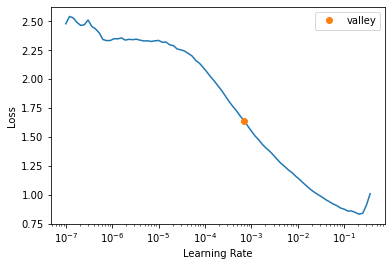

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.764455,1.089494,0.562500,00:09
1,1.083835,0.341217,0.892857,00:08
2,0.784708,0.200004,0.946429,00:09
3,0.597272,0.151468,0.955357,00:08
4,0.477258,0.155412,0.955357,00:09
5,0.384791,0.169215,0.946429,00:09
6,0.323914,0.173487,0.946429,00:09
7,0.273584,0.172082,0.946429,00:09
8,0.237643,0.165515,0.946429,00:08
9,0.210010,0.164638,0.946429,00:09


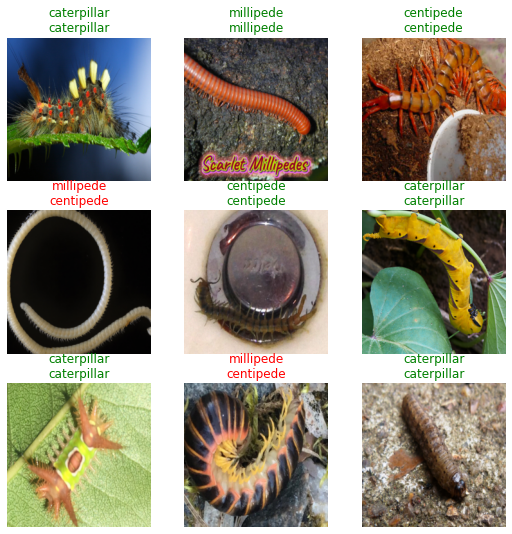

In [11]:
learn.show_results()

In [10]:
learn.export()

# Pushing to huggingface for usage later.

In [13]:
!pip install -Uqq huggingface_hub["fastai"]

In [15]:
from huggingface_hub import notebook_login
notebook_login()